# Single Cell Sequencing: data analysis II function (campari information)

Here we use information from function and campari to check our clustering.


In [13]:
!pip install --quiet anndata
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
import anndata as ad
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt
import os 
#doublet detection
import scrublet as scr
#batch correction (not installed by default in the docker container, install via command line: pip install scanorama bbknn)
import scanorama as scan
#external modules
import scanpy.external as sce
#pretty plotting
import seaborn as sb
import sys 
sb.set_context(context='poster')
from matplotlib import rcParams


sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80)

scanpy==1.9.4 anndata==0.9.2 umap==0.5.3 numpy==1.24.4 scipy==1.11.2 pandas==2.1.0 scikit-learn==1.3.0 statsmodels==0.14.0 igraph==0.10.3 louvain==0.8.0 pynndescent==0.5.10


## SECTION I: Data loading

Loading adata information that has been agregated and quality controled

In [14]:
figure_path = '/home/melma31/Documents/single_cell_sequencing/figures/'
input_path = '/home/melma31/Documents/single_cell_sequencing/output/'

adata = ad.read_h5ad(input_path + 'campari_scs_umap.h5ad')

## SECTION II: Funtional exploration

Now we add the information we have about stimuli for each cell and level of campari green and red fluorecence. 

Here we define the stimuli that were used (this assignation of number and id is the one that is used in the plate information excel sheet): 


* 0: control
* 1: pinch
* 2: new_stroke (after december)
* 3: ballon
* 4: AG (ano-genital brush)
* 5: AD (anal distension)
* 6: heating
* 7: mock
* 8: old_stoke (first experiments with stroke)
* 9: anal pinch
* 10: mock with poop
* 11: tomatoe
* 12: poop

In [15]:
rcParams['figure.figsize']=(4,4)

labels=['Control','pinch','new_stroke','ballon','AG','AD','heating','mock','old_stroke','anal_pinch','mock_w_poop','vaginal_distension','tomatoe','poop']
color = ['gainsboro','green','darkorange','purple','magenta','cyan','red','orange','yellow','brown','orange','blue','violet','k']


### create and exportable varable list of genes names
gene_name = []
for i in range(len(adata.var['gene_name'])):
    gene_name.append(adata.var['gene_name'].iloc[i])
### transform adata sparse matrix to scipy
x = adata.X
### create exportable arrays with information about stimuli, fluorecence, and louvain transformations
stim = np.zeros((x.shape[0],))
red = np.zeros((x.shape[0],))
green = np.zeros((x.shape[0],))
for i in range(x.shape[0]):
    stim[i] = adata.obs['stimulus'][i]
    red[i] = adata.obs['red'][i]
    green[i] = adata.obs['green'][i]



/tmp/ipykernel_4581/475451686.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stim[i] = adata.obs['stimulus'][i]
/tmp/ipykernel_4581/475451686.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  red[i] = adata.obs['red'][i]
/tmp/ipykernel_4581/475451686.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  green[i] = adata.obs['green'][i]


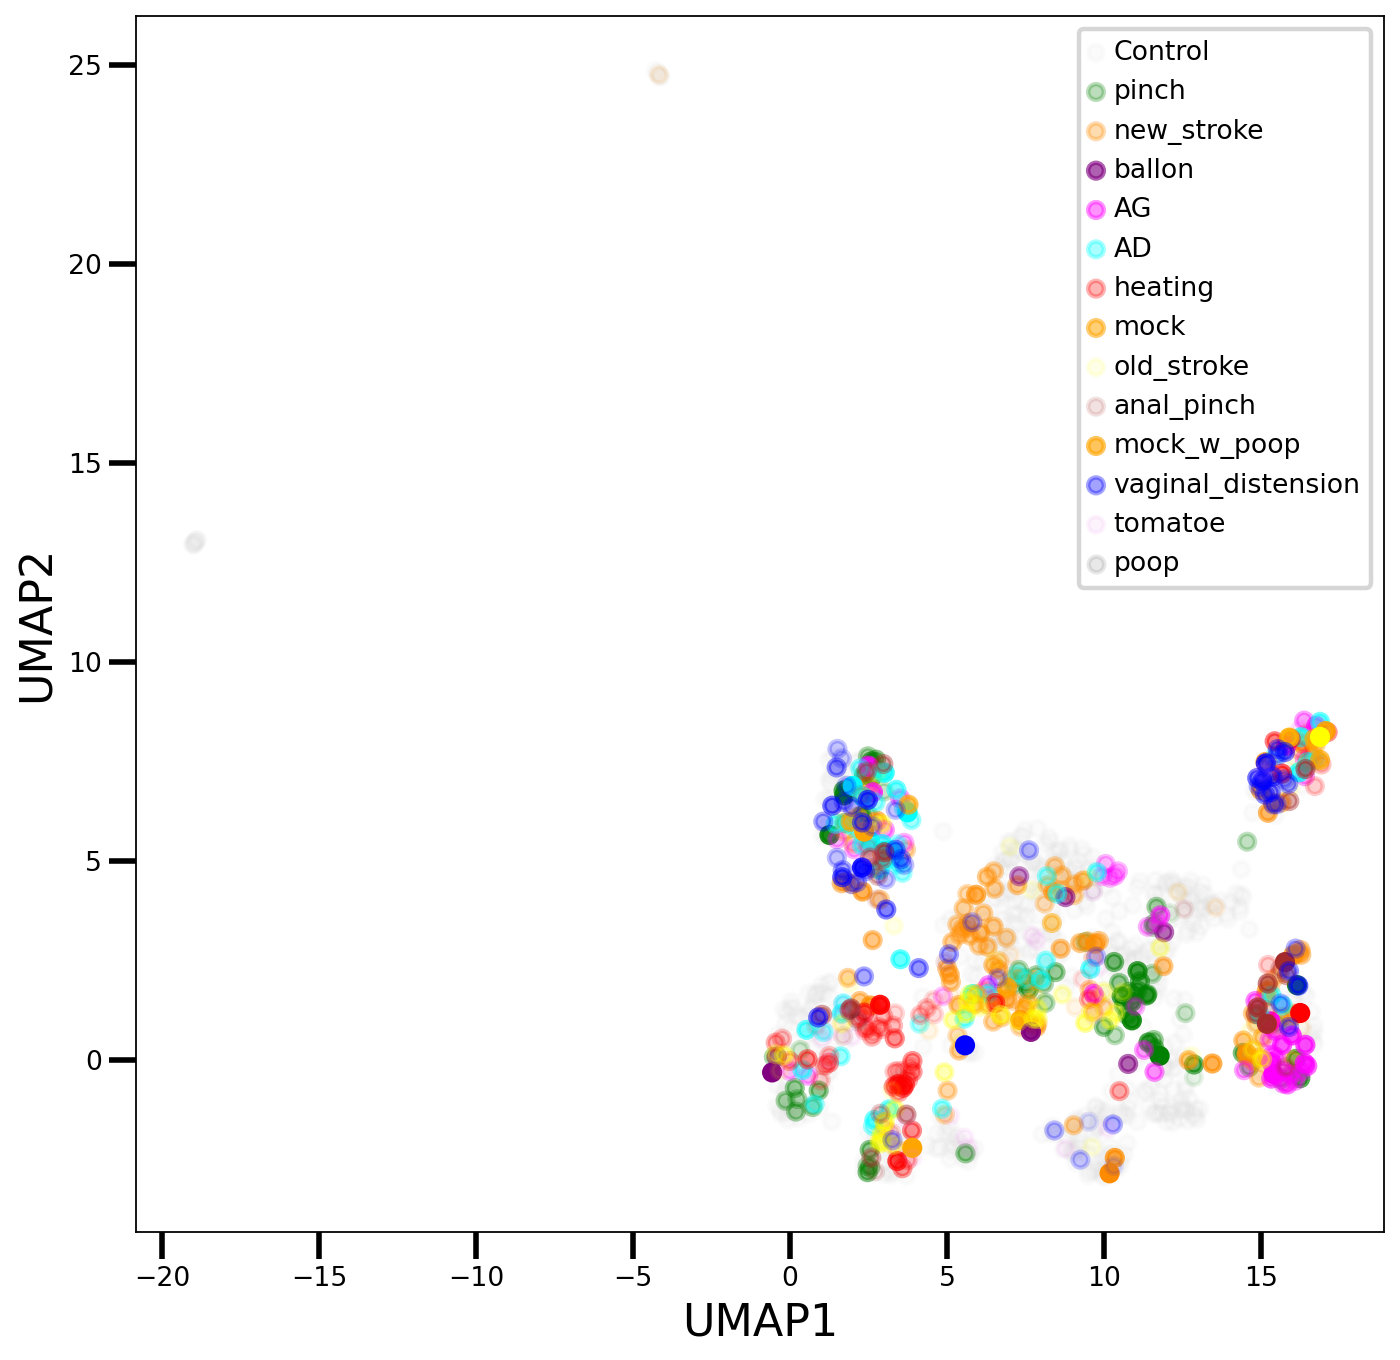

In [16]:
### plotting all stimulus together

figure, axes = plt.subplots()
#red_norm = (red - np.min(red)) / (np.max(red) - np.min(red))
for i in range(len(labels)):
    index = np.where(stim == i)[0]
    red_norm = (red[index] - np.min(red[index])) / (np.max(red[index]) - np.min(red[index]) + sys.float_info.epsilon)
    red_norm = (red_norm + 0.1)/1.1
    axes.scatter(adata.obsm['X_umap'][index,0],adata.obsm['X_umap'][index,1], s = 50, c = color[i], alpha = red_norm)
axes.grid(visible = 'None')
#axes.set_xlim([0,19])
#axes.set_ylim([0,19])
axes.set_xlabel('UMAP1', fontsize = 20)
axes.set_ylabel('UMAP2', fontsize = 20)
axes.tick_params(axis='both', which='major', labelsize=12)
axes.tick_params(axis='both', which='minor', labelsize=12)
axes.grid(False)

axes.legend(labels, fontsize = 12)
#sc.pl.umap(adata, color = 'stimulus', color_map = 'Set1', save = 'stimulus'+ '.png', size = 180)
figure.set_size_inches([10,10])
figure.savefig(figure_path + 'stimulus.png')

(629, 14995)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


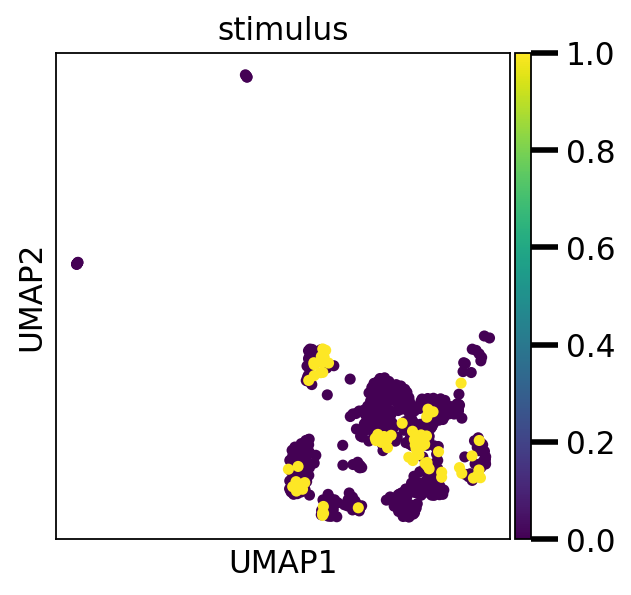

(686, 14995)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


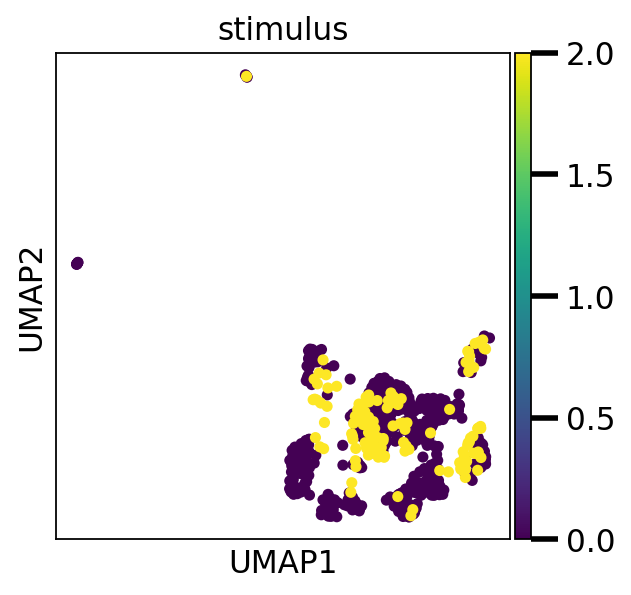

(561, 14995)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


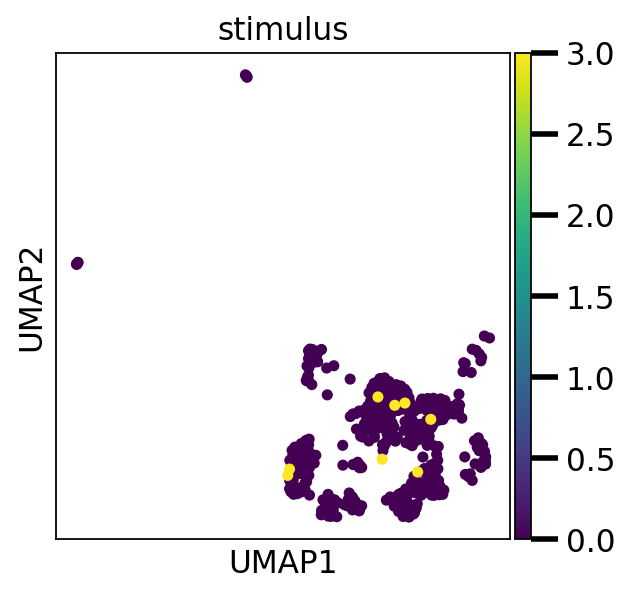

(604, 14995)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


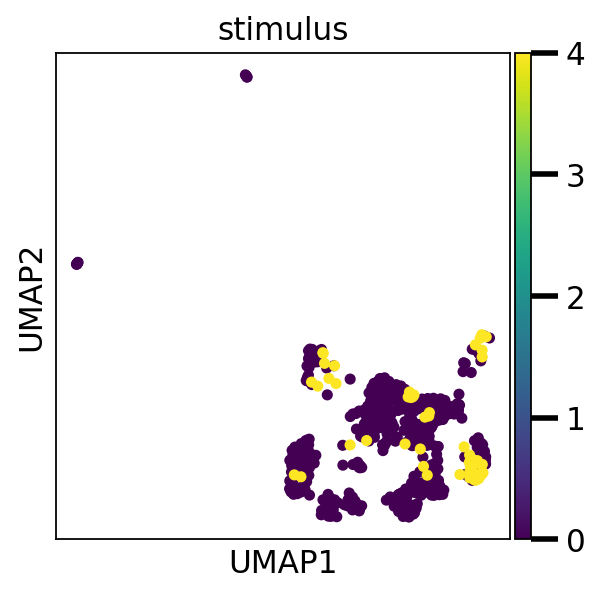

(614, 14995)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


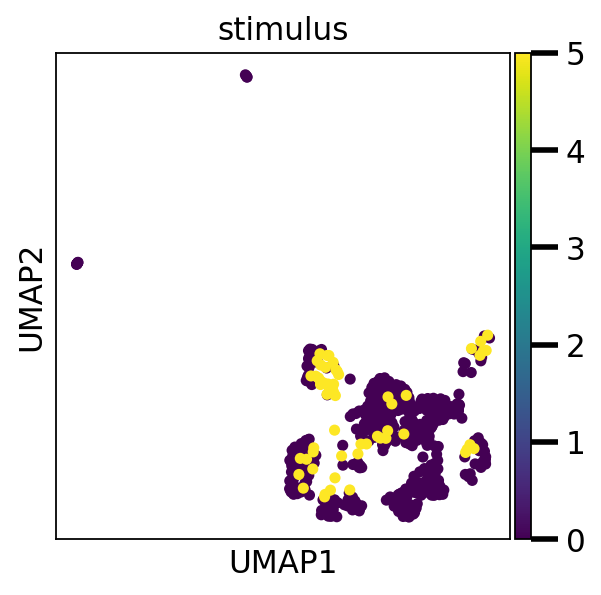

(616, 14995)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


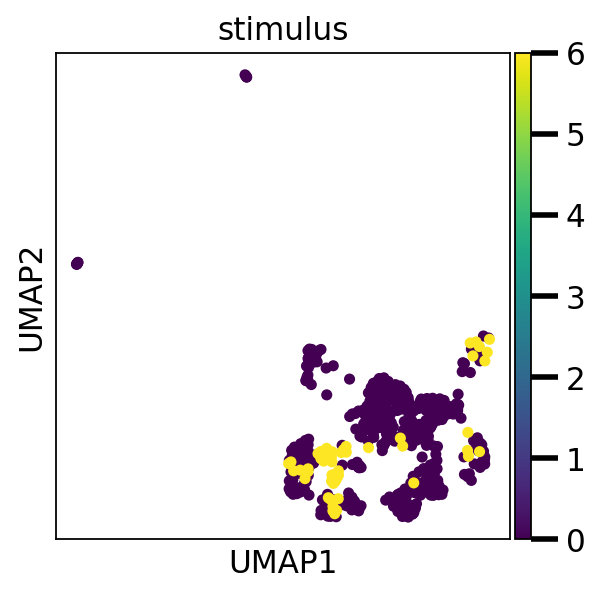

(569, 14995)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


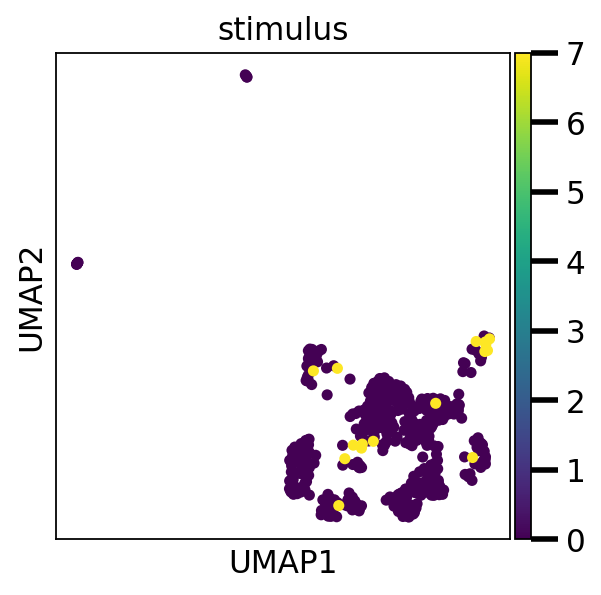

(608, 14995)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


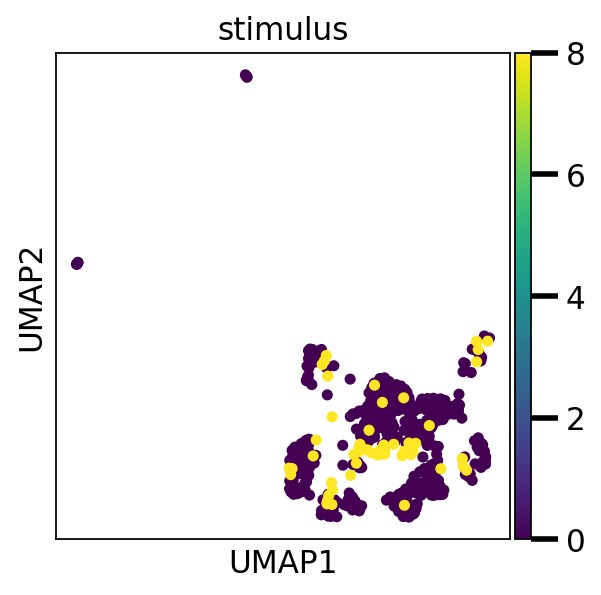

(585, 14995)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


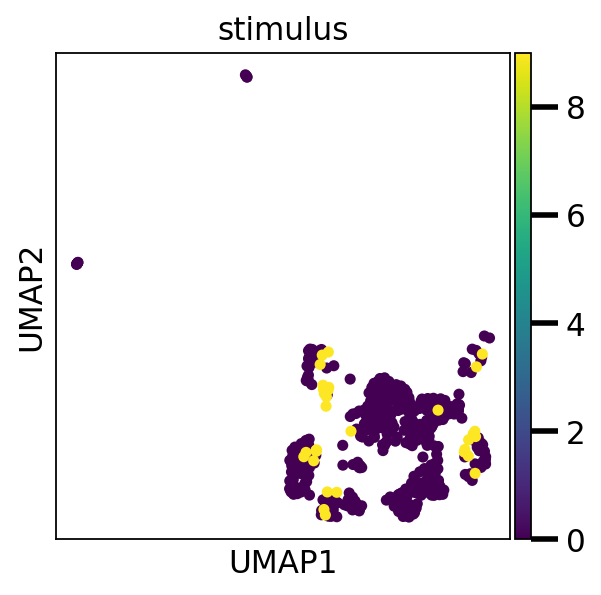

(557, 14995)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


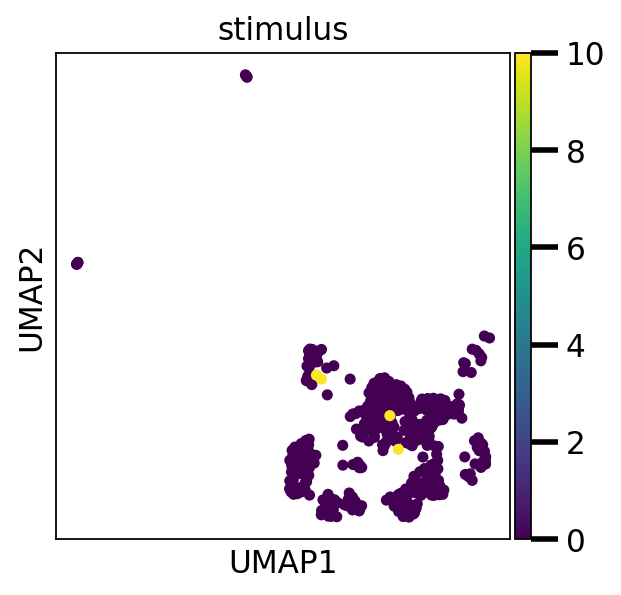

(612, 14995)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


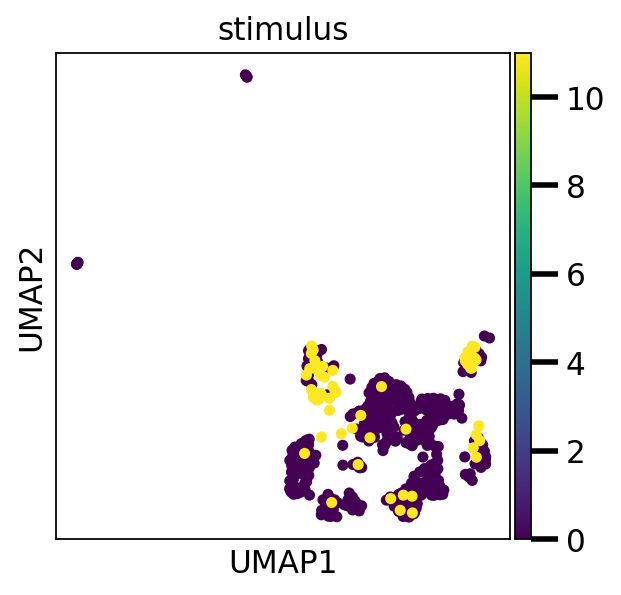

(575, 14995)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


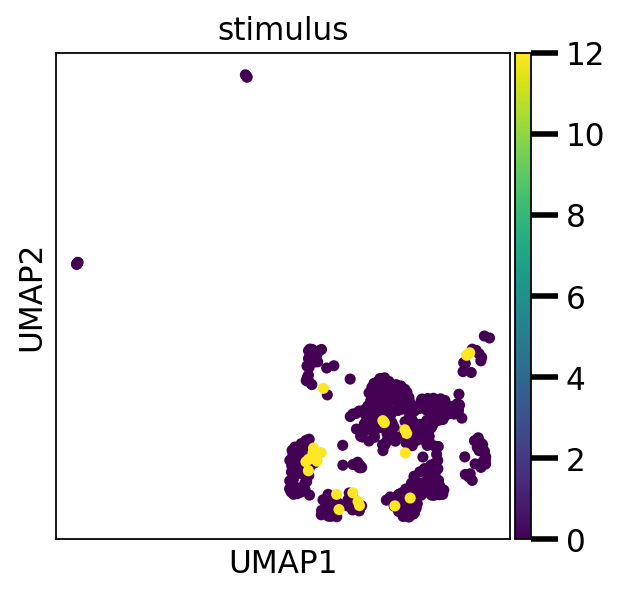

(554, 14995)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


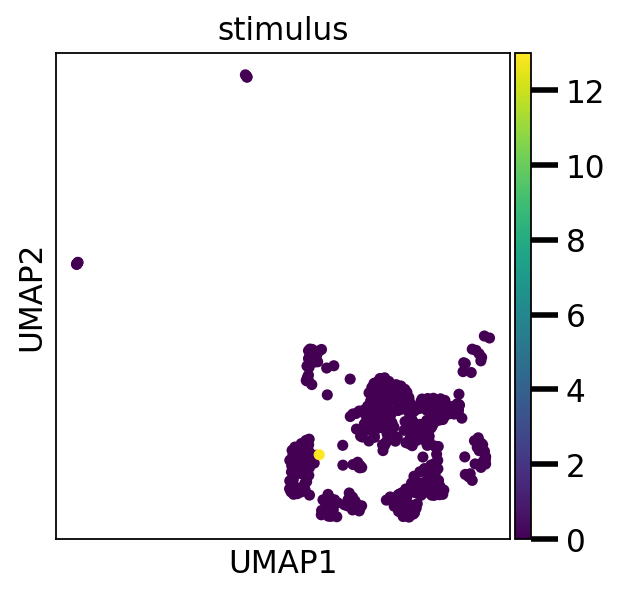

In [17]:
### plotting stimuli individualy

rcParams['figure.figsize']=(4,4)

for i in range(1,14):
    index = np.logical_or(adata.obs['stimulus'] == i,adata.obs['stimulus'] == 0)
    aux_adata = adata[index,:]
    print(aux_adata.shape)
    sc.pl.umap(aux_adata, color = 'stimulus', color_map = 'viridis', save = 'UMIs/stimulus/stimulus_' + labels[i]+ '.png', size = 100)

0
[]
4
[0]
5
[0, 4]
2
[0, 4, 5]
1
[0, 4, 5, 2]
9
[0, 4, 5, 2, 1]
6
[0, 4, 5, 2, 1, 9]
11
[0, 4, 5, 2, 1, 9, 6]
12
[0, 4, 5, 2, 1, 9, 6, 11]


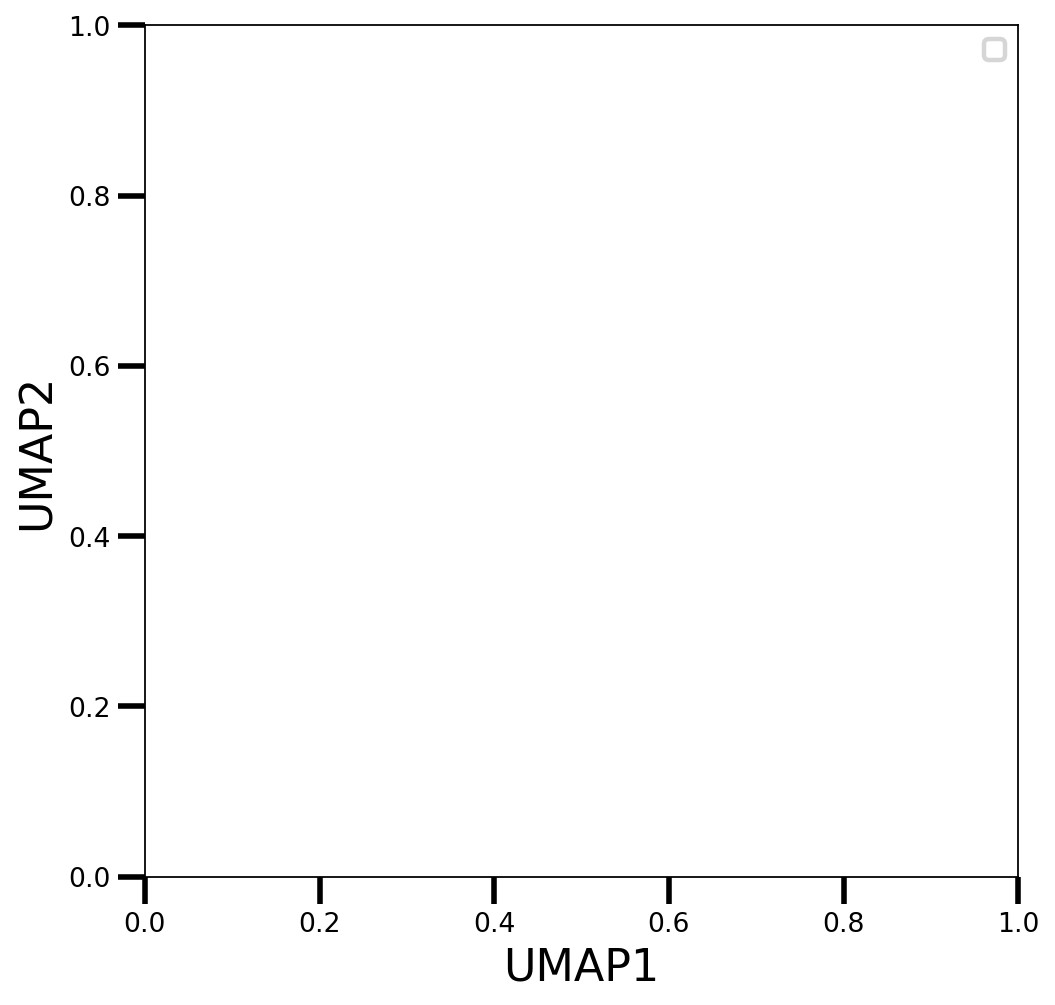

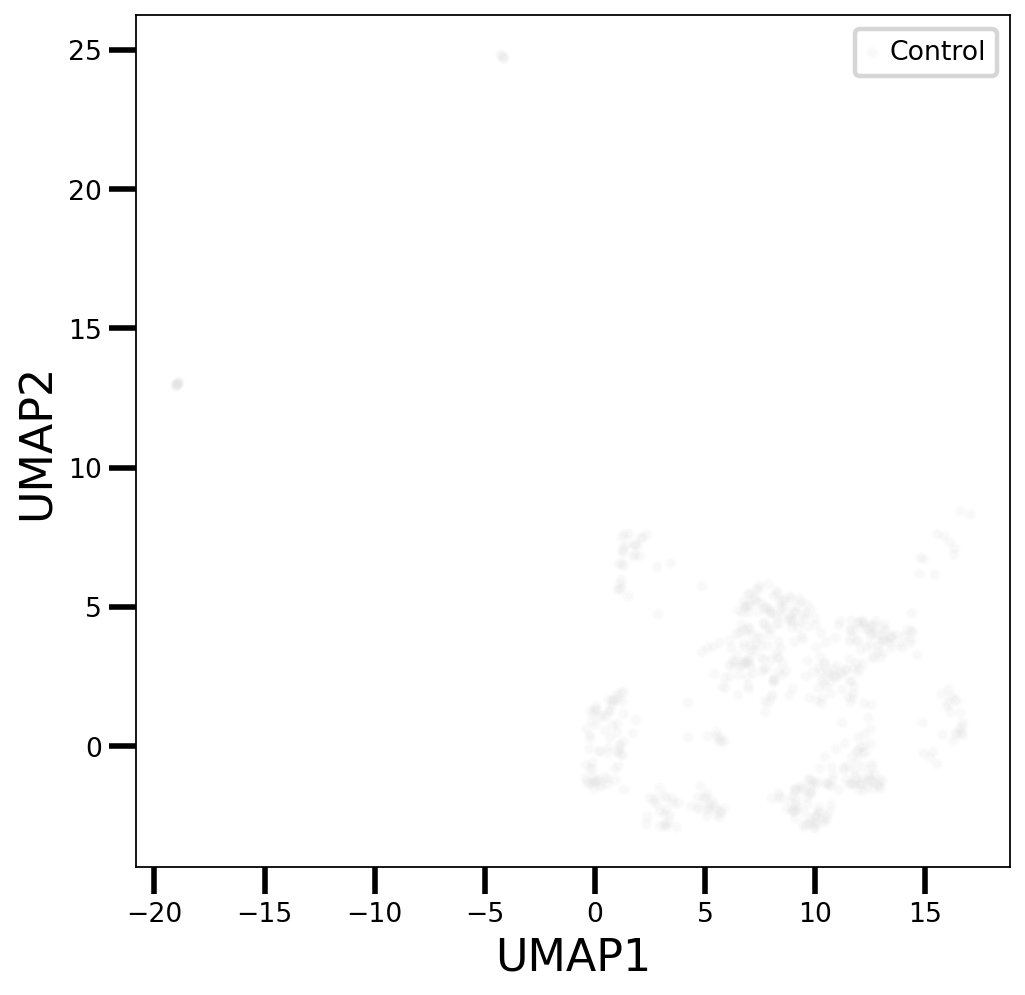

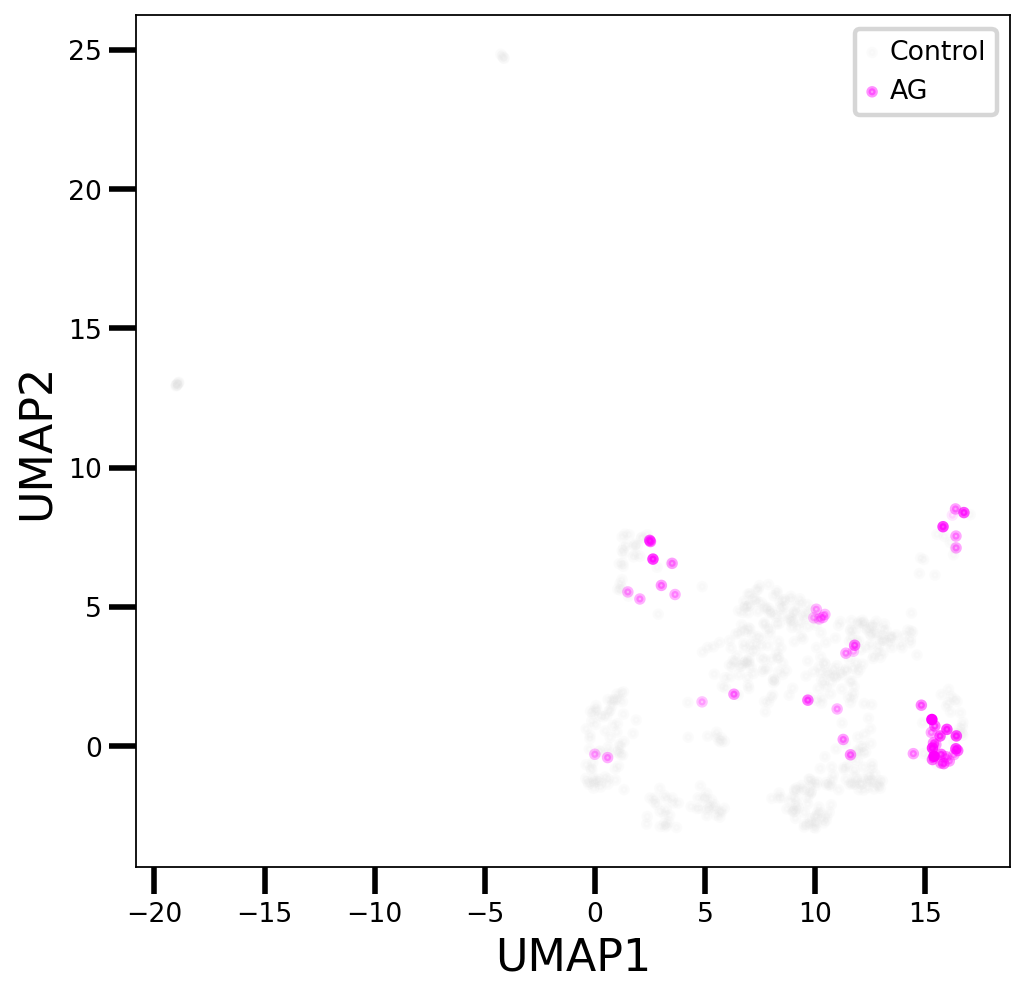

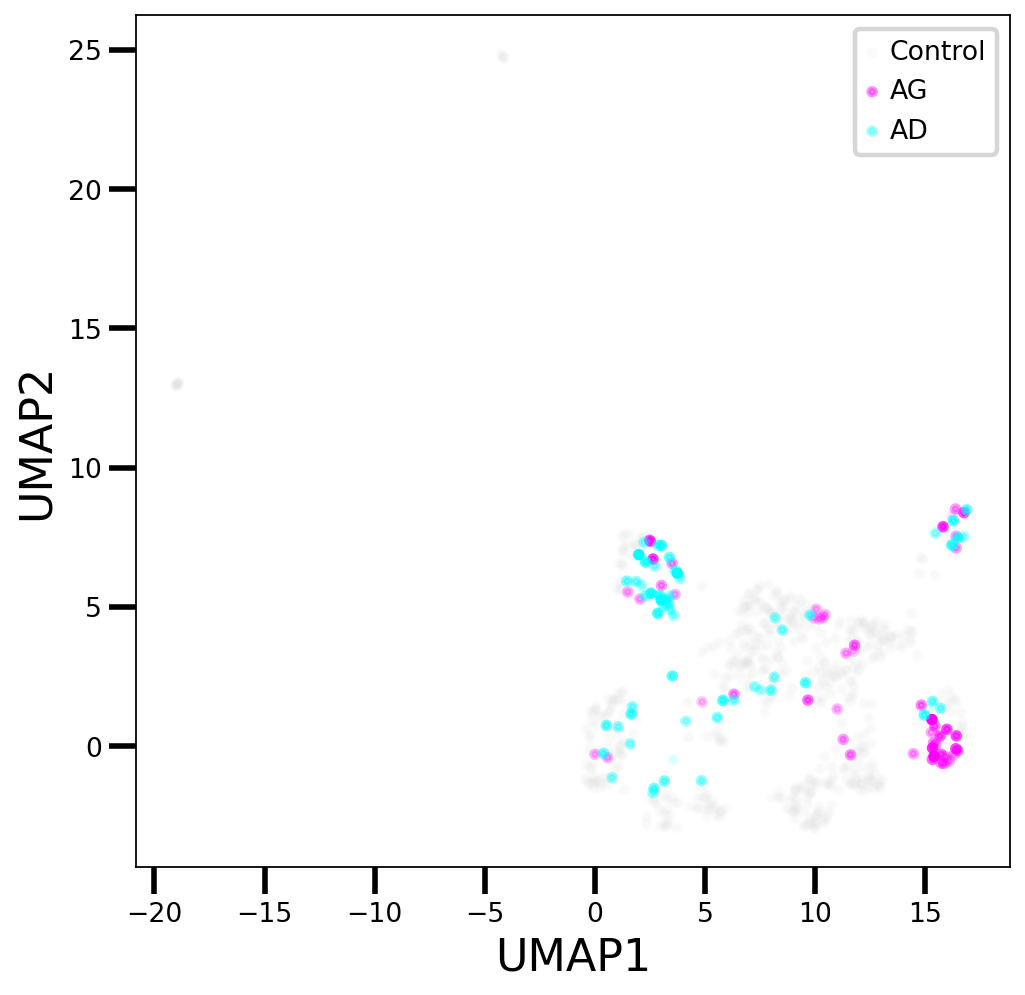

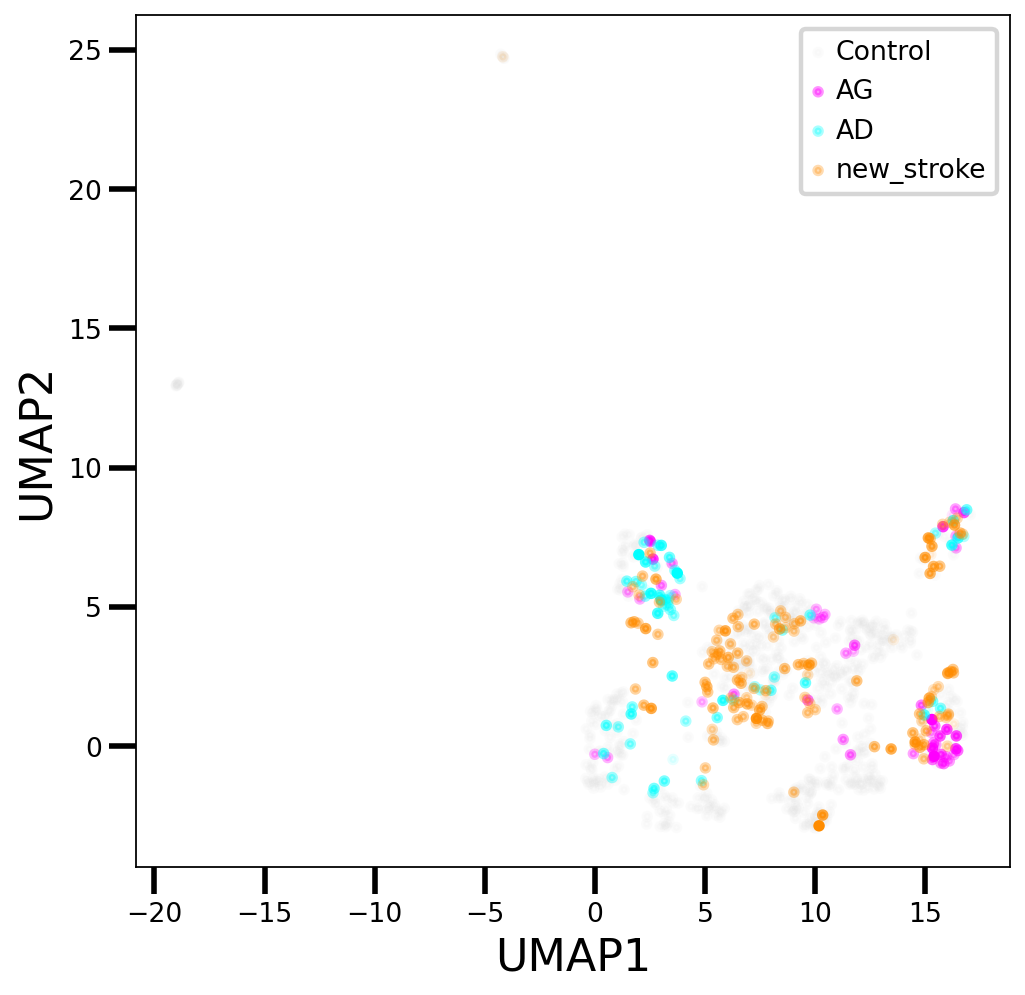

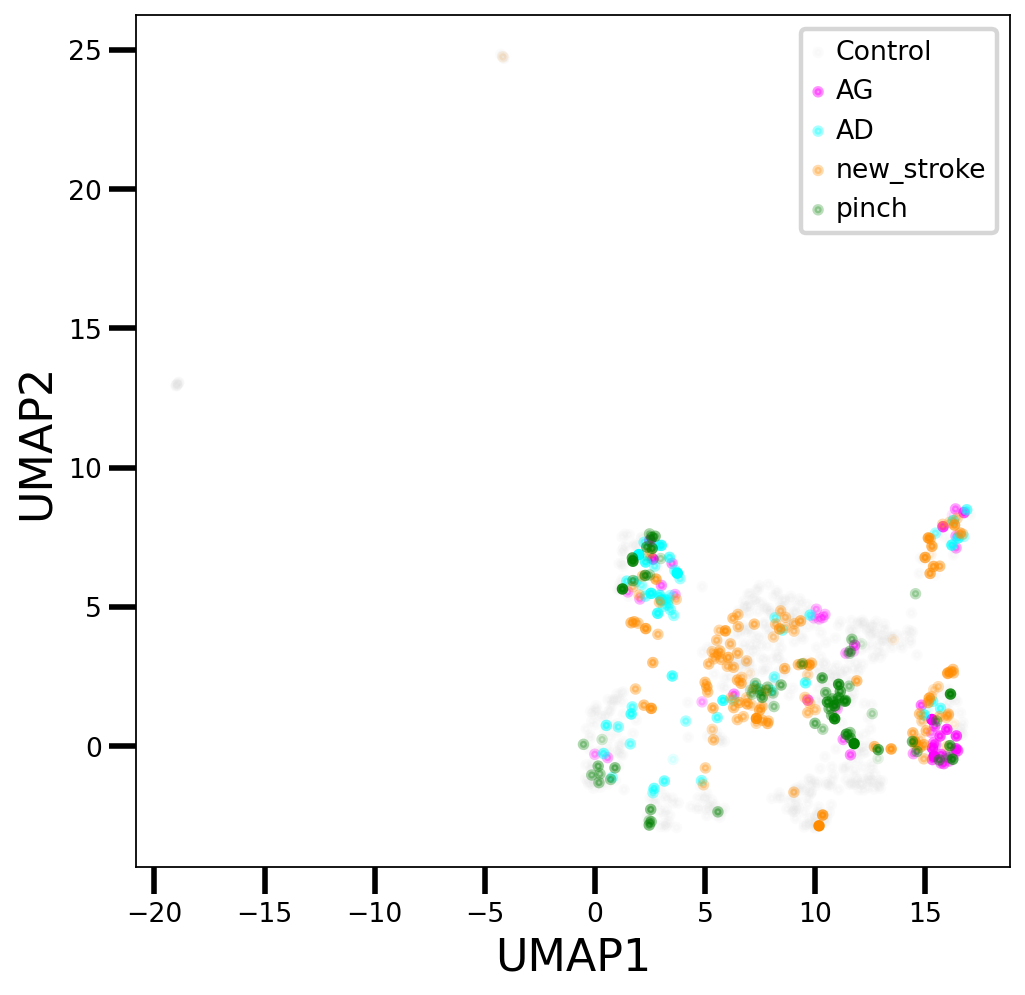

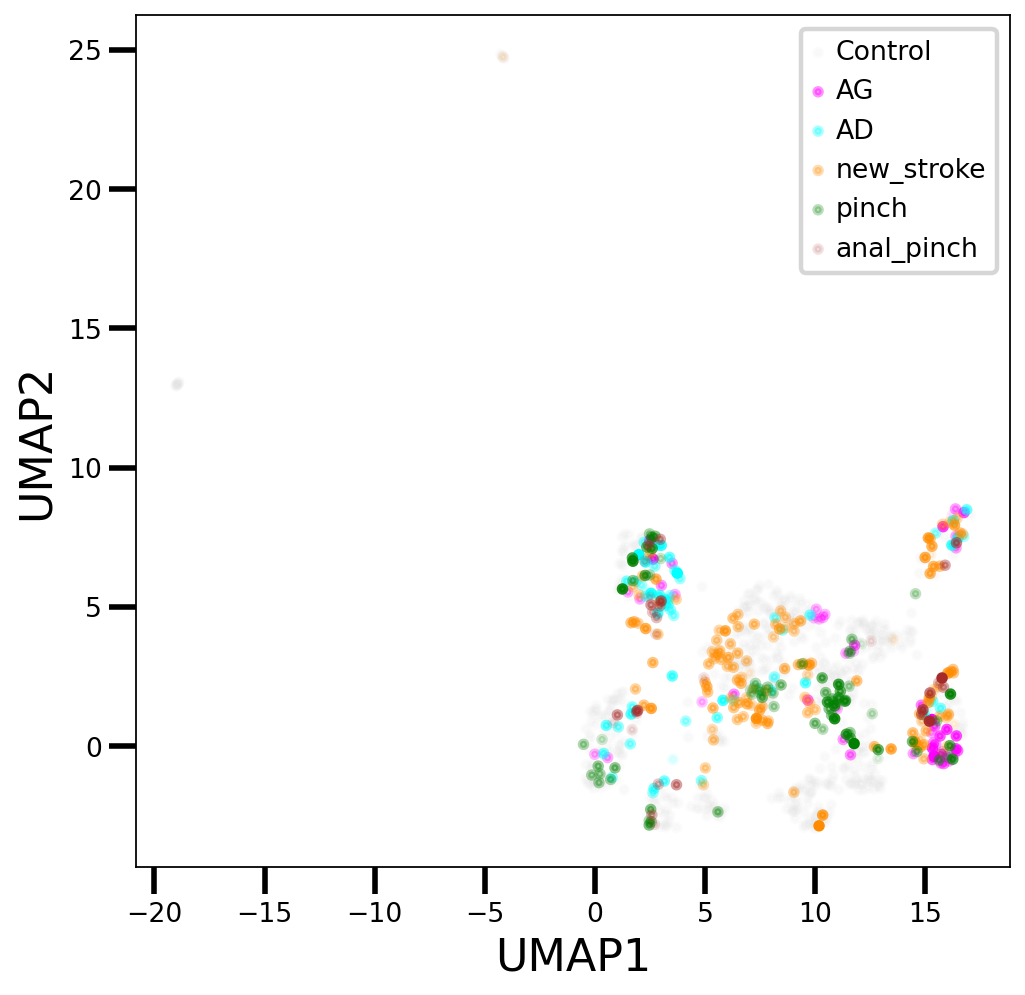

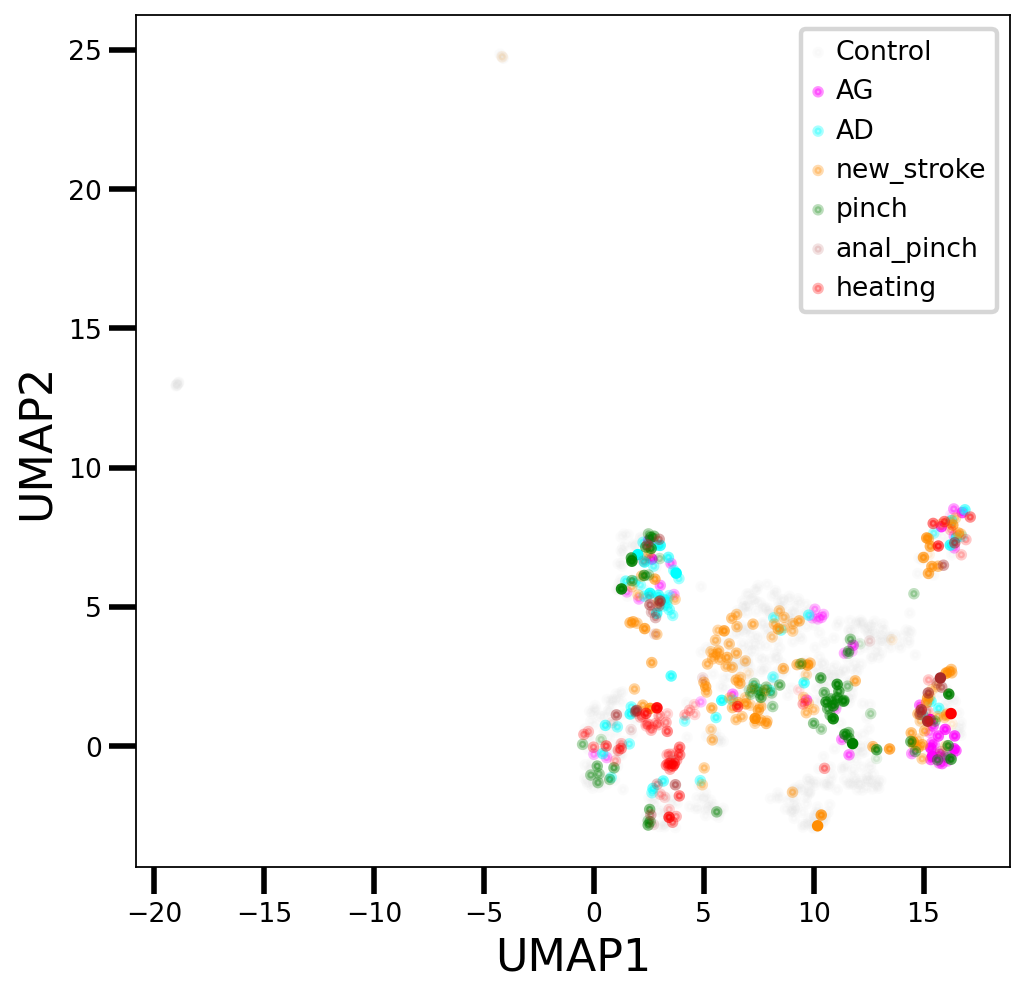

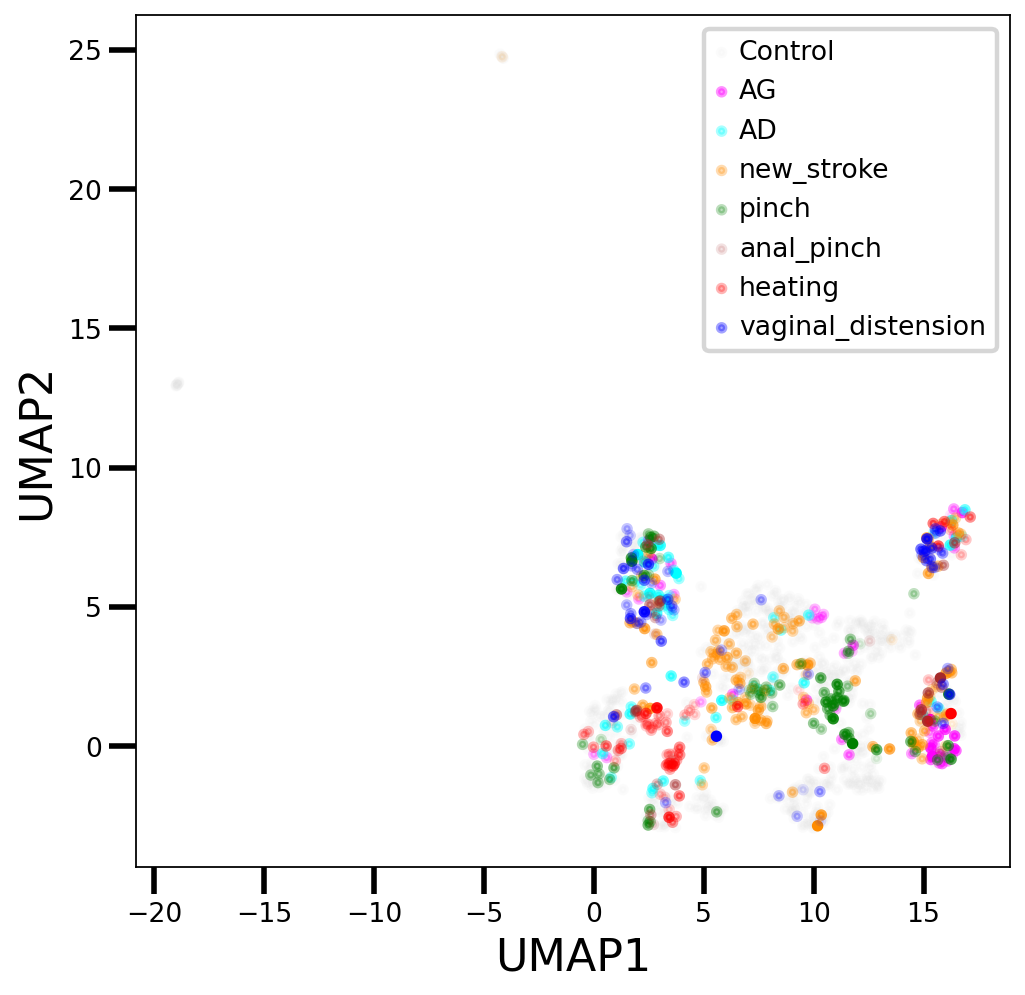

In [18]:
### plotting subsequent stimulus to add individually in a gif (only for selected stimuli)
stimulus_list = [0,4,5,2,1,9,6,11,12]
new_labels=['Control','AG','AD','new_stroke','pinch','anal_pinch','heating','vaginal_distension','non']
count = 0
for i in stimulus_list:
    print(i)
    figure, axes = plt.subplots()
    sublist = stimulus_list[0:count]
    print(sublist)
    for j in sublist:
        index = np.where(stim == j)[0]
        red_norm = (red[index] - np.min(red[index])) / (np.max(red[index]) - np.min(red[index]) + sys.float_info.epsilon)
        red_norm = (red_norm + 0.1)/1.1
        axes.scatter(adata.obsm['X_umap'][index,0],adata.obsm['X_umap'][index,1], s = 10, c = color[j],alpha = red_norm)

    axes.grid(visible = 'None')
    #axes.set_xlim([0,22])
    #axes.set_ylim([0,22])
    axes.set_xlabel('UMAP1', fontsize = 20)
    axes.set_ylabel('UMAP2', fontsize = 20)
    axes.tick_params(axis='both', which='major', labelsize=12)
    axes.tick_params(axis='both', which='minor', labelsize=12)
    axes.grid(False)
    axes.legend(new_labels, fontsize = 12)
    figure.set_size_inches([7,7])
    figure.savefig(figure_path + 'cum_stimulus'+ str(count) +'.png')

    count = count +1 

/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


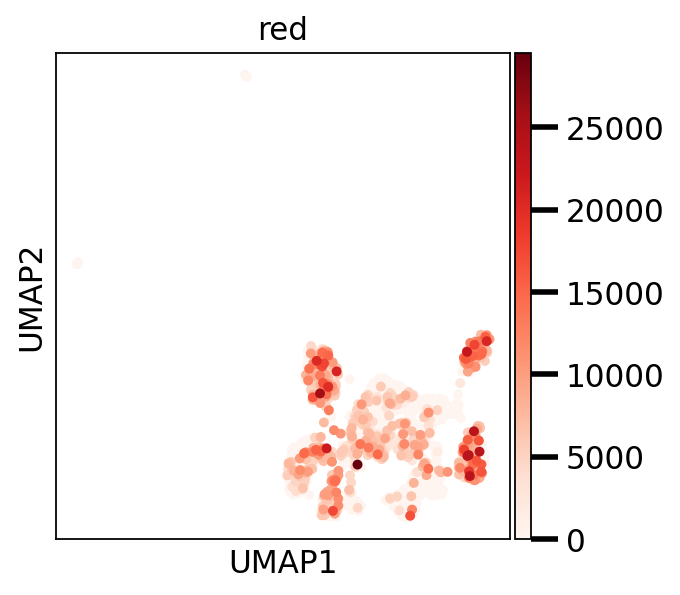

/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


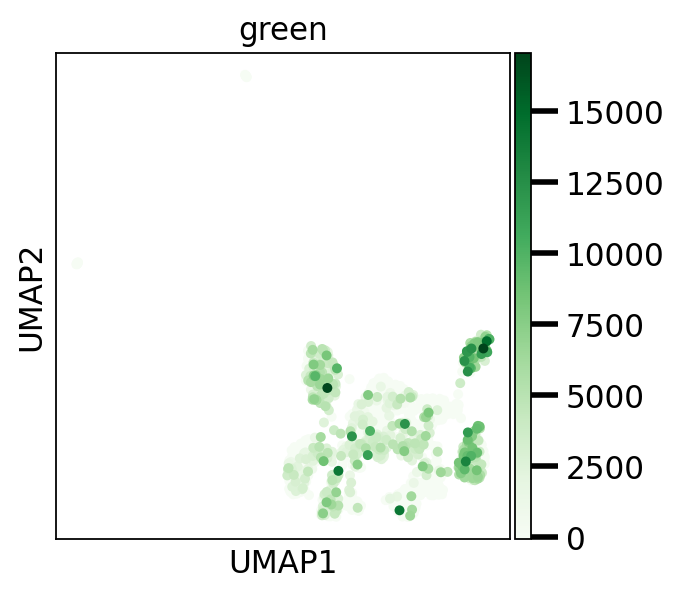

/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


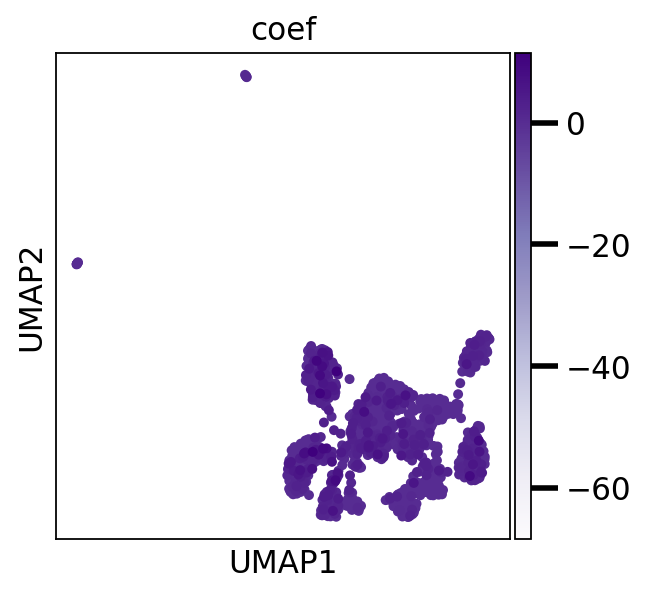

In [19]:
### plotting fluorecence levels 

sc.pl.umap(adata, color='red', color_map = 'Reds', save = 'UMIs/fluorecence/red_f' + '.png', size = 80)
sc.pl.umap(adata, color='green', color_map = 'Greens', save = 'UMIs/fluorecence/green_f' + '.png', size = 80)
adata.obs['coef'] = adata.obs['red']/(adata.obs['green'] + sys.float_info.epsilon)
sc.pl.umap(adata, color='coef', color_map = 'Purples', save = 'UMIs/fluorecence/coef_f' + '.png', size = 80)


(629, 14995)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


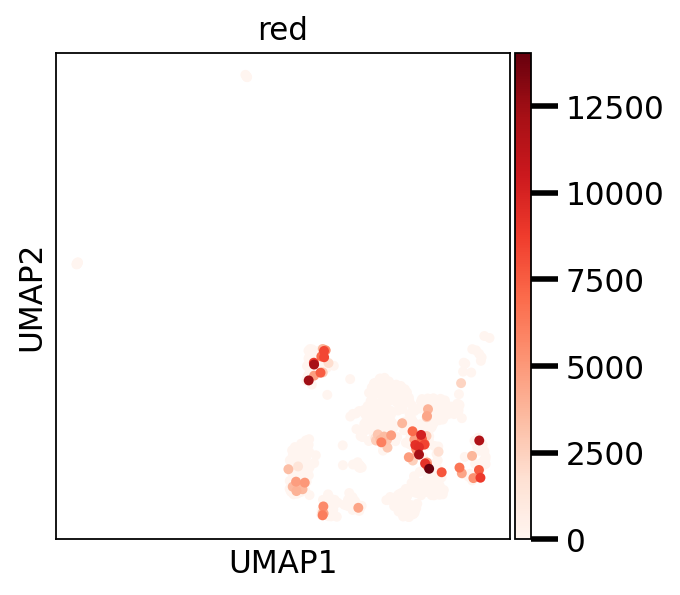

(686, 14995)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


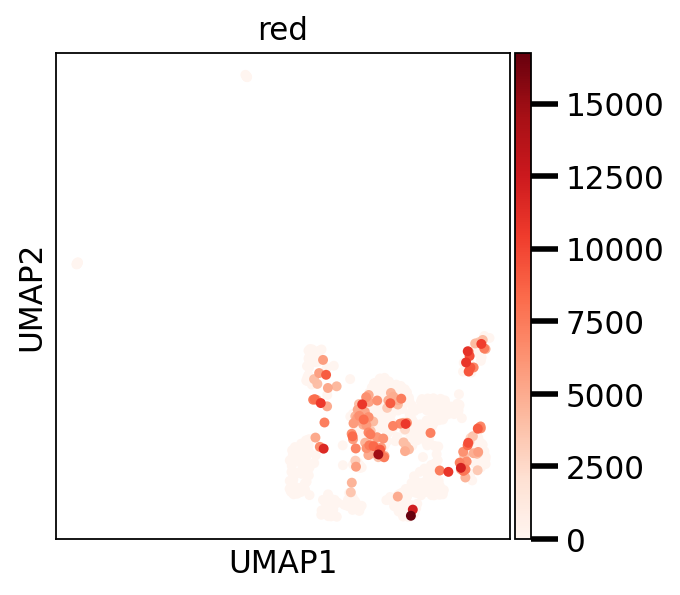

(561, 14995)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


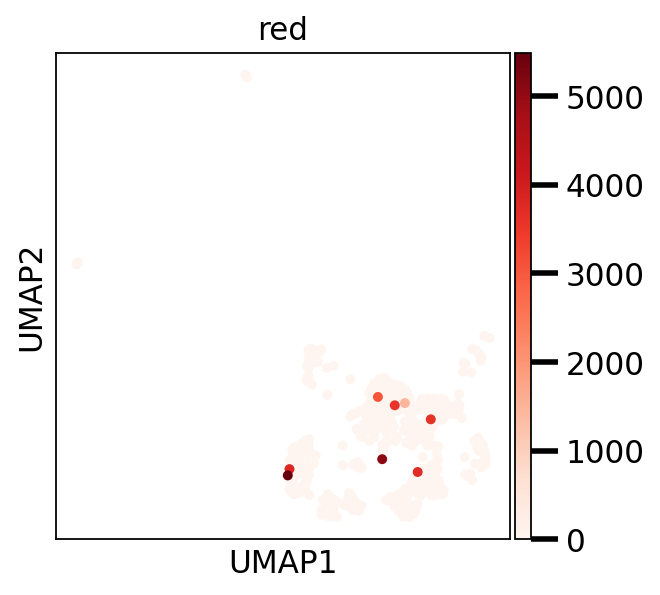

(604, 14995)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


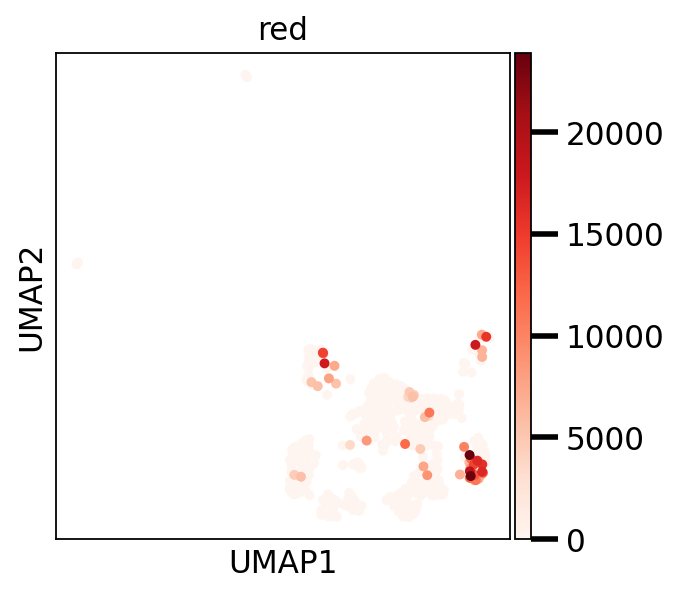

(614, 14995)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


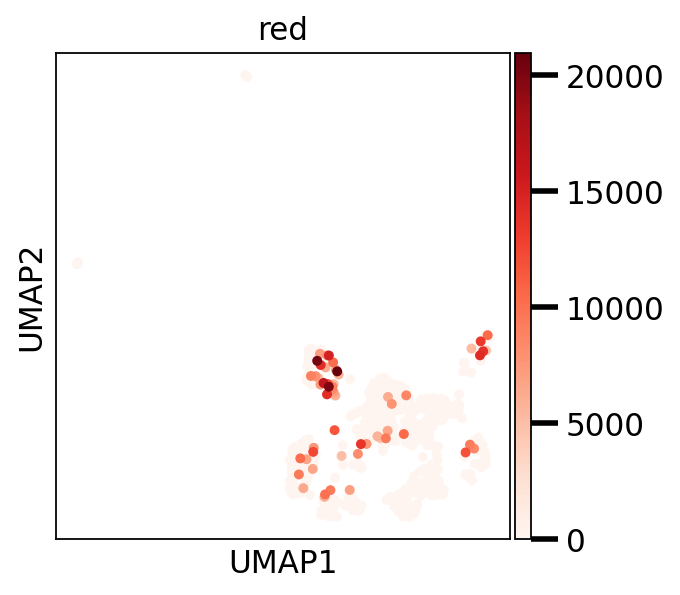

(616, 14995)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


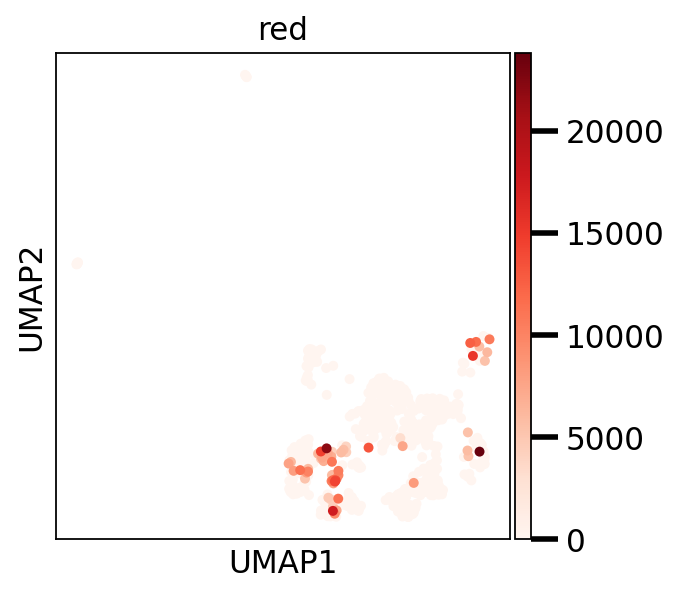

(569, 14995)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


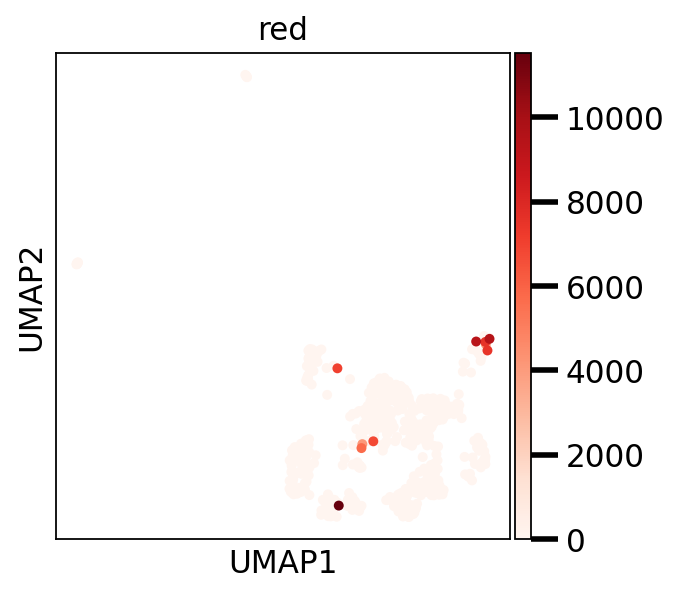

(608, 14995)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


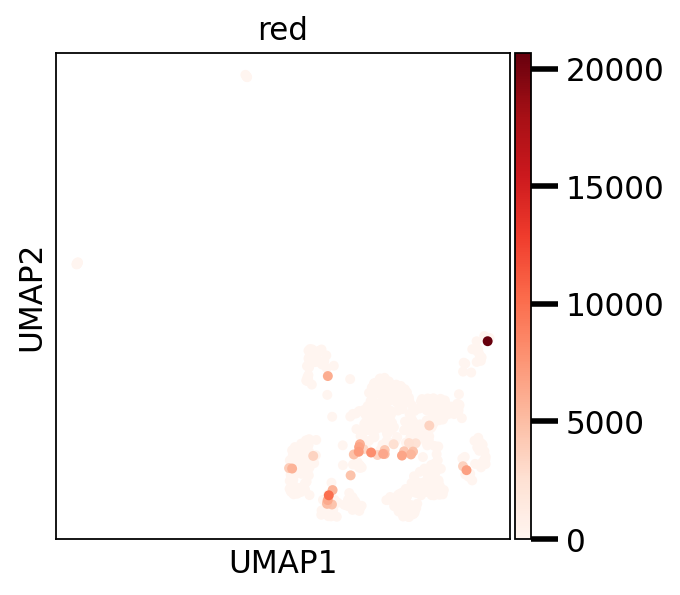

(585, 14995)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


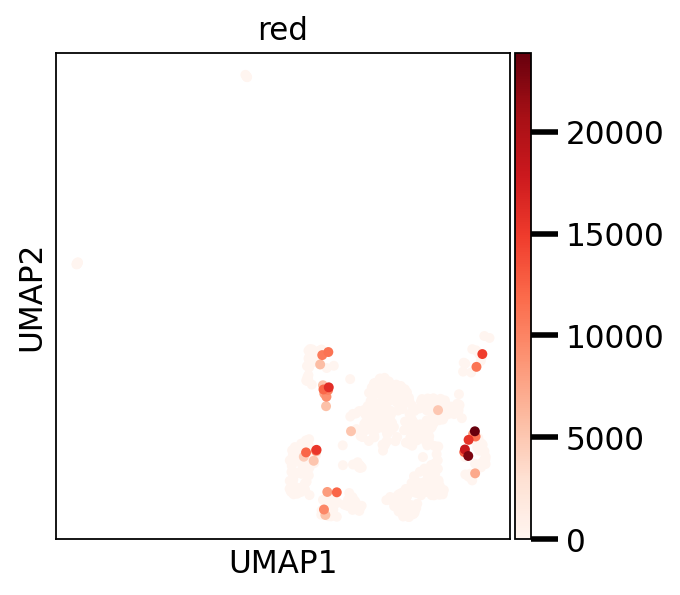

(557, 14995)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


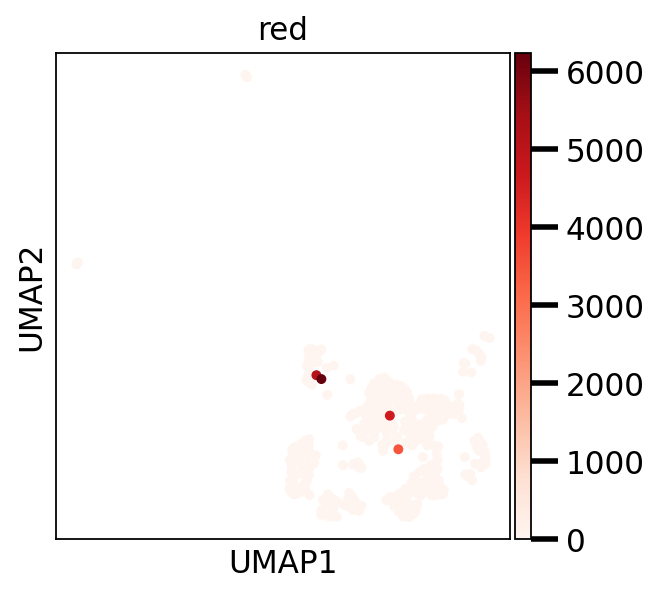

(612, 14995)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


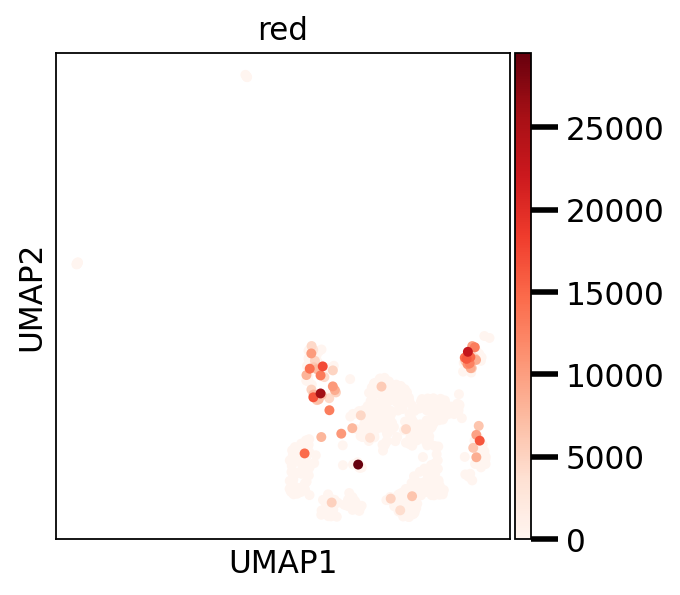

(575, 14995)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


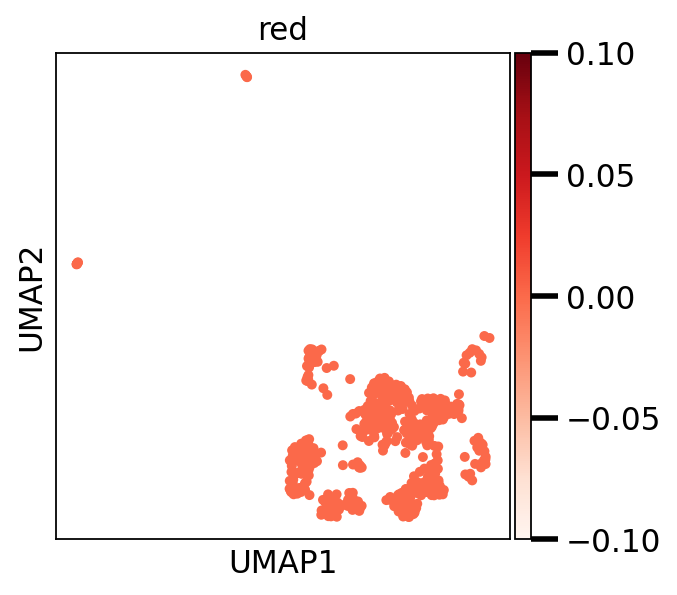

(554, 14995)


/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


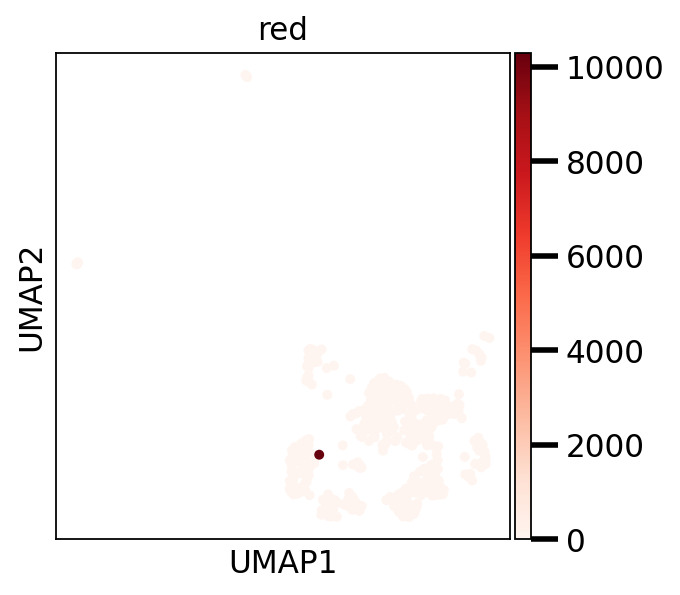

In [20]:
### plotting fluorecence levels stimulus by stimulus
for i in range(1,14):
    index = np.logical_or(adata.obs['stimulus'] == i,adata.obs['stimulus'] == 0)
    aux_adata = adata[index,:]
    print(aux_adata.shape)
    sc.pl.umap(aux_adata, color = 'red', color_map = 'Reds', save = 'UMIs/fluorecence/stimulus_red_' + labels[i]+ '.png', size = 80)


In [75]:
#print(adata.obs['louvain_r2'])
stimulus_variable = adata.obs['louvain_r2']
stimulus_variable.name = 'stimulus_'
print(stimulus_variable)
stimulus_variable.cat.set_categories(['0', '1', '2','3','4','5','6','7','8','9','10','11','12'], rename=True)
print(stimulus_variable)

print(len(stimulus_variable))
for i in range(len(stimulus_variable)):
    stimulus_variable.iloc[i] = str(adata.obs['stimulus'][i])
    
print(stimulus_variable)
adata.obs['stimulus_'] = stimulus_variable

sc.tl.rank_genes_groups(adata, 'stimulus_', method='wilcoxon')
rank_genes_df = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(15)

barcode
TCCGATAACTCACTAACCGG-sample1-sample12     0
TCCGATAACTCACAATCCAC-sample1-sample12     6
TTCACCACGGCACAATCCAC-sample1-sample12     6
TTCACCACGGCACTAACCGG-sample1-sample12     6
TTCACCAGCTCACTAACCGG-sample1-sample12     8
                                         ..
GAACCTGACCTGGAGTTACA-sample3              0
CCGACTTAGTGACCTGAAGA-sample3              7
TACTTGTGCATTCACGTCAG-sample3             12
TTACTGGCAGTGGAGTTACA-sample3              8
TACTTGTGCATTACTGTCGT-sample3             12
Name: stimulus_, Length: 1134, dtype: category
Categories (15, object): ['0', '1', '2', '3', ..., '11', '12', '13', '14']
barcode
TCCGATAACTCACTAACCGG-sample1-sample12     0
TCCGATAACTCACAATCCAC-sample1-sample12     6
TTCACCACGGCACAATCCAC-sample1-sample12     6
TTCACCACGGCACTAACCGG-sample1-sample12     6
TTCACCAGCTCACTAACCGG-sample1-sample12     8
                                         ..
GAACCTGACCTGGAGTTACA-sample3              0
CCGACTTAGTGACCTGAAGA-sample3              7
TACTTGTGCATTCACGTCAG-sampl

/tmp/ipykernel_4581/2187656313.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stimulus_variable.iloc[i] = str(adata.obs['stimulus'][i])


TypeError: Cannot setitem on a Categorical with a new category (1.0), set the categories first

In [69]:
rank_genes_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,Adcyap1,Prkcq,Rarres1,Negr1,Tbx3os2,Atpaf2,Asic3,P2rx6,Pvalb,Smyd3,Tatdn1,Cysltr2,Ndrg1,Cdh13,Klhl6
1,Celf4,Mrgprd,Rnf112,Pcsk1,Baiap2l1,Trh,Cplx2,Nefm,Clec2l,Mrgpra3,Bc1,Osmr,Cryab,Gm9670,Smox
2,Tmem176a,Scg3,D130079A08Rik,Esr1,Ntrk2,Cct6a,Serpinb1a,Lgi3,Aldoc,Mrgprx1,Rpl36,Htr1f,Plekhb1,Skint3,Ntn1
3,Tac1,Grik1,Gm7271,Mrap2,Cadps2,Gm36189,Cgnl1,Pcp4,Atp1a3,Tmprss11c,Polr2l,Il31ra,Mbp,Gm46606,D030062O11Rik
4,Gal,Cd55,Cd34,Mgat4a,Rom1,Gm45832,Ly6h,Tagln3,Hs3st2,Adora2b,Gm26725,Jak1,Mpz,Ifnab,Tgfbi
5,Trpv1,Rab27b,Wfdc2,Ache,Kcnk1,Dnajb14,Abcg2,Nkiras1,Sparcl1,Krt27,Tmsb10,Blvrb,Qk,Gm5907,Ly6d
6,Tmem176b,P2rx3,Tafa4,6330403K07Rik,Necab2,Gm8173,Cpne6,Nefl,Sh3bgr,Crip2,Gm49847,Adk,Art3,Npy4r,Gm44187
7,Gpx3,Gm765,Smyd1,Chst2,Slc6a19,Gm15265,Gng8,Cabp7,Wls,Mical1,Gm10076,Gpr139,Gpm6b,Gm47061,Gm37676
8,Tmem100,Fam167a,Kcnd3,Pou4f3,Ehd3,Gm40477,Mgll,Cpne6,Runx3,Capn5,G630016G05Rik,Pde4c,Mt1,Stc1,Gm50313
9,Calca,Ctxn3,Cdh9,Rab3b,Tbx3,Gm37565,Hopx,S100b,Slc17a7,Cd82,2610306O10Rik,Ptprk,Dbi,Fxyd6,Lamc3
